# Baseline model to predict the first two digits of NAICS

The objective of this notebook is to create a baseline model to predict the first two digits of the NAICS code.

The main idea is to use TF-IDF to vectorize the text data and then try some simple models to predict the first two digits of the NAICS code.


In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), "../", "data"))
NAICS_DATA = os.path.join(DATA_DIR, "processed/coverwallet.xlsx")
SYNTHETIC_DATA = os.path.join(DATA_DIR, "processed/total_naics_synthetic.csv")

In [20]:
df = pd.read_excel(NAICS_DATA)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14182 entries, 0 to 14181
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NAICS                 14180 non-null  float64
 1   BUSINESS_DESCRIPTION  14177 non-null  object 
dtypes: float64(1), object(1)
memory usage: 221.7+ KB


In [22]:
df.head()

,NAICS,BUSINESS_DESCRIPTION
0,722511.0,Zenyai Viet Cajun & Pho Restaurant is dedicate...
1,541330.0,"Kilduff Underground Engineering, Inc. (KUE) is..."
2,453998.0,024™ is a premium home fragrance brand that de...
3,561720.0,Our Services include Office Cleaning Carpet cl...
4,621610.0,NYS Licensed Home Health Agency


In [23]:
# null data rows
df[df.isnull().any(axis=1)]

,NAICS,BUSINESS_DESCRIPTION
1248,561311.0,NaN
1492,325992.0,NaN
1989,811310.0,NaN
5196,541430.0,NaN
9149,541990.0,NaN
11535,NaN,JRC GROUP LLC. Is an ASSET BASED freight broke...
13486,NaN,Consulting services for Facility Asset Managem...


In [24]:
df.dropna(inplace=True)

In [25]:
synthetic_df = pd.read_csv(SYNTHETIC_DATA)

In [26]:
synthetic_df.rename(columns={"naics_2": "NAICS_2"}, inplace=True)
synthetic_df.head()

,NAICS,BUSINESS_DESCRIPTION,NAICS_2
0,211111,This establishment is engaged in the explorati...,21
1,212311,This business is involved in the mining and qu...,21
2,212321,This company specializes in the mining and pro...,21
3,213112,This establishment is engaged in the explorati...,21
4,213115,This business provides support services for oi...,21


We will use the first two digits of NAICS, so let's create a new column with this information.


In [27]:
df["NAICS_2"] = df["NAICS"].astype(str).str[:2].astype(int)
df.head()

,NAICS,BUSINESS_DESCRIPTION,NAICS_2
0,722511.0,Zenyai Viet Cajun & Pho Restaurant is dedicate...,72
1,541330.0,"Kilduff Underground Engineering, Inc. (KUE) is...",54
2,453998.0,024™ is a premium home fragrance brand that de...,45
3,561720.0,Our Services include Office Cleaning Carpet cl...,56
4,621610.0,NYS Licensed Home Health Agency,62


In [28]:
df["NAICS_2"].value_counts()

NAICS_2
54    4202
23    2976
56    1159
61     751
33     682
42     650
62     517
81     488
51     380
72     333
53     331
71     300
48     270
32     241
45     240
31     184
52     162
44     148
49      45
22      32
92      30
11      26
55      15
21      13
Name: count, dtype: int64

The dataset is certainly imbalanced, so we will use the `stratify` parameter in the `train_test_split` function to ensure that the distribution of the target variable is the same in the training and test sets.


In [29]:
from sklearn.model_selection import train_test_split

X = df["BUSINESS_DESCRIPTION"]
y = df["NAICS_2"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11340,), (2835,), (11340,), (2835,))

In [30]:
# add synthetic data to training data
X_train = pd.concat([X_train, synthetic_df["BUSINESS_DESCRIPTION"]])
y_train = pd.concat([y_train, synthetic_df["NAICS_2"]])

In [31]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12990,), (2835,), (12990,), (2835,))

In [32]:
print(y_train.value_counts())

NAICS_2
54    3361
23    2381
56     927
61     601
33     552
42     520
62     414
81     390
48     307
51     304
55     272
72     266
22     266
53     265
21     250
71     240
11     231
52     230
92     224
31     223
44     218
32     211
45     192
49     145
Name: count, dtype: int64


In [33]:
print(y_test.value_counts())

NAICS_2
54    841
23    595
56    232
61    150
33    136
42    130
62    103
81     98
51     76
72     67
53     66
71     60
48     54
45     48
32     48
31     37
52     32
44     30
49      9
92      6
22      6
11      5
55      3
21      3
Name: count, dtype: int64


## KMeans classifier


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [35]:
clf = Pipeline(
    [
        ("vectorizer_tfidf", TfidfVectorizer()),
        ("KNN", KNeighborsClassifier(n_neighbors=5)),
    ]
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          11       0.09      0.20      0.12         5
          21       0.06      0.33      0.10         3
          22       0.06      0.17      0.09         6
          23       0.70      0.87      0.78       595
          31       0.38      0.38      0.38        37
          32       0.48      0.33      0.40        48
          33       0.60      0.35      0.44       136
          42       0.19      0.58      0.29       130
          44       0.33      0.17      0.22        30
          45       0.64      0.15      0.24        48
          48       0.51      0.72      0.60        54
          49       0.75      0.33      0.46         9
          51       0.45      0.18      0.26        76
          52       0.67      0.69      0.68        32
          53       0.76      0.68      0.72        66
          54       0.79      0.72      0.75       841
          55       0.00      0.00      0.00         3
          56       0.79    

## Naive Bayes classifier


In [36]:
from sklearn.naive_bayes import MultinomialNB

clf = Pipeline(
    [
        ("vectorizer_tfidf", TfidfVectorizer()),
        ("NB", MultinomialNB()),
    ]
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          11       1.00      0.20      0.33         5
          21       0.00      0.00      0.00         3
          22       1.00      0.17      0.29         6
          23       0.64      0.84      0.72       595
          31       0.00      0.00      0.00        37
          32       0.00      0.00      0.00        48
          33       0.91      0.07      0.14       136
          42       0.77      0.08      0.14       130
          44       0.00      0.00      0.00        30
          45       0.00      0.00      0.00        48
          48       0.00      0.00      0.00        54
          49       0.00      0.00      0.00         9
          51       0.00      0.00      0.00        76
          52       0.00      0.00      0.00        32
          53       1.00      0.02      0.03        66
          54       0.42      0.97      0.58       841
          55       0.00      0.00      0.00         3
          56       0.90    

/home/ernesto/.cache/pypoetry/virtualenvs/zrive-ds-ZlIsFOKS-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ernesto/.cache/pypoetry/virtualenvs/zrive-ds-ZlIsFOKS-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ernesto/.cache/pypoetry/virtualenvs/zrive-ds-ZlIsFOKS-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

## Random Forest classifier


In [37]:
from sklearn.ensemble import RandomForestClassifier

clf = Pipeline(
    [
        ("vectorizer_tfidf", TfidfVectorizer()),
        ("RF", RandomForestClassifier(n_estimators=100)),
    ]
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          11       0.25      0.20      0.22         5
          21       0.33      0.33      0.33         3
          22       0.33      0.17      0.22         6
          23       0.74      0.89      0.80       595
          31       0.44      0.11      0.17        37
          32       0.64      0.15      0.24        48
          33       0.57      0.40      0.47       136
          42       0.43      0.45      0.44       130
          44       0.17      0.03      0.06        30
          45       0.50      0.08      0.14        48
          48       0.66      0.43      0.52        54
          49       0.50      0.11      0.18         9
          51       0.67      0.03      0.05        76
          52       0.92      0.34      0.50        32
          53       0.79      0.45      0.58        66
          54       0.58      0.93      0.71       841
          55       0.00      0.00      0.00         3
          56       0.78    

## First conclusions

The KMeans classifier had the best performance, according to the accuracy and F1-score metrics. The Naive Bayes classifier had the worst performance, and the Random Forest classifier had intermediate performance, close to the KMeans classifier.

To improve the performance of the models, we can try to preprocess the text data, such as removing stopwords, punctuation, and using lemmatization or stemming.


## Text preprocessing


Let's preprocess the data and create the models.


In [37]:
import spacy

In [38]:
nlp = spacy.load("en_core_web_trf")


def preprocess(sentence: str):
    doc = nlp(sentence)
    word_list = [word.lemma_ for word in doc if not (word.is_stop or word.is_punct)]
    return " ".join(word_list)

/home/ernesto/.cache/pypoetry/virtualenvs/zrive-ds-ZlIsFOKS-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
synthetic_df["PREPROCESSED_DESCRIPTION"] = synthetic_df["BUSINESS_DESCRIPTION"].apply(
    preprocess
)

In [ ]:
df["PREPROCESSED_DESCRIPTION"] = df["BUSINESS_DESCRIPTION"].apply(preprocess)

We'll save the dataframe just because it will save time in the preprocessing step in the future.


In [ ]:
# df.to_parquet(os.path.join(DATA_DIR, "processed/coverwallet_preprocessed.parquet"))

In [40]:
# synthetic_df.to_parquet(
#    os.path.join(DATA_DIR, "processed/synthetic_preprocessed.parquet")
# )

Let's read the data preprocessed


In [38]:
synthetic_df = pd.read_parquet(
    os.path.join(DATA_DIR, "processed/synthetic_preprocessed.parquet")
)

In [3]:
df = pd.read_parquet(
    os.path.join(DATA_DIR, "processed/coverwallet_preprocessed.parquet")
)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    df["PREPROCESSED_DESCRIPTION"],
    df["NAICS_2"],
    test_size=0.2,
    random_state=42,
    stratify=df["NAICS_2"],
)

In [41]:
# add synthetic data to training data
X_train = pd.concat([X_train, synthetic_df["PREPROCESSED_DESCRIPTION"]])
y_train = pd.concat([y_train, synthetic_df["NAICS_2"]])

## KNN classifier for preprocessed data


In [42]:
clf = Pipeline(
    [
        ("vectorizer_tfidf", TfidfVectorizer()),
        ("RF", KNeighborsClassifier()),
    ]
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          11       0.13      0.40      0.20         5
          21       0.07      0.33      0.11         3
          22       0.08      0.33      0.13         6
          23       0.70      0.88      0.78       595
          31       0.29      0.27      0.28        37
          32       0.42      0.29      0.35        48
          33       0.60      0.40      0.48       136
          42       0.21      0.56      0.30       130
          44       0.31      0.17      0.22        30
          45       0.56      0.19      0.28        48
          48       0.51      0.72      0.60        54
          49       0.30      0.33      0.32         9
          51       0.40      0.22      0.29        76
          52       0.61      0.78      0.68        32
          53       0.72      0.74      0.73        66
          54       0.80      0.69      0.74       841
          55       0.00      0.00      0.00         3
          56       0.77    

### Hyperparameter tuning


In [44]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "RF__n_neighbors": [10, 15, 20, 25],
}

clf = Pipeline(
    [
        ("vectorizer_tfidf", TfidfVectorizer()),
        ("RF", KNeighborsClassifier()),
    ]
)

grid_search = GridSearchCV(clf, parameters, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

grid_search.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


{'RF__n_neighbors': 20}

Let's train the KNN classifier with the preprocessed data and the best hyperparameters found.


In [45]:
clf = Pipeline(
    [
        ("vectorizer_tfidf", TfidfVectorizer()),
        ("RF", KNeighborsClassifier(n_neighbors=20)),
    ]
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          11       0.19      0.60      0.29         5
          21       0.09      0.33      0.14         3
          22       0.04      0.17      0.06         6
          23       0.72      0.92      0.81       595
          31       0.50      0.38      0.43        37
          32       0.64      0.33      0.44        48
          33       0.66      0.35      0.45       136
          42       0.46      0.47      0.47       130
          44       0.44      0.27      0.33        30
          45       0.62      0.17      0.26        48
          48       0.62      0.69      0.65        54
          49       0.27      0.44      0.33         9
          51       0.50      0.17      0.25        76
          52       0.60      0.78      0.68        32
          53       0.71      0.82      0.76        66
          54       0.75      0.84      0.79       841
          55       0.00      0.00      0.00         3
          56       0.78    

## Other models


Let's see if we can improve the performance of the models by using other models and try some hyperparameter tuning.


### Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = Pipeline(
    [
        ("vectorizer_tfidf", TfidfVectorizer()),
        ("LR", LogisticRegression()),
    ]
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          11       0.50      0.40      0.44         5
          21       0.00      0.00      0.00         3
          22       0.25      0.17      0.20         6
          23       0.81      0.91      0.86       595
          31       0.55      0.32      0.41        37
          32       0.68      0.27      0.39        48
          33       0.62      0.60      0.61       136
          42       0.57      0.57      0.57       130
          44       0.78      0.23      0.36        30
          45       0.53      0.17      0.25        48
          48       0.77      0.63      0.69        54
          49       1.00      0.22      0.36         9
          51       0.58      0.18      0.28        76
          52       0.85      0.72      0.78        32
          53       0.83      0.61      0.70        66
          54       0.67      0.90      0.77       841
          55       0.00      0.00      0.00         3
          56       0.79    

/home/ernesto/.cache/pypoetry/virtualenvs/zrive-ds-ZlIsFOKS-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ernesto/.cache/pypoetry/virtualenvs/zrive-ds-ZlIsFOKS-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ernesto/.cache/pypoetry/virtualenvs/zrive-ds-ZlIsFOKS-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

In [ ]:
# regularization
from sklearn.preprocessing import StandardScaler

parameters = {
    "LR__penalty": ["l1", "l2", None],
    "LR__C": [0.1, 1, 2],
}

clf = Pipeline(
    [
        ("vectorizer_tfidf", TfidfVectorizer()),
        ("standard_scaler", StandardScaler(with_mean=False)),
        ("LR", LogisticRegression(solver="liblinear")),
    ]
)

grid_search = GridSearchCV(clf, parameters, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/ernesto/.cache/pypoetry/virtualenvs/zrive-ds-ZlIsFOKS-py3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ernesto/.cache/pypoetry/virtualenvs/zrive-ds-ZlIsFOKS-py3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ernesto/.cache/pypoetry/virtualenvs/zrive-ds-ZlIsFOKS-py3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_

              precision    recall  f1-score   support

          11       0.25      0.20      0.22         5
          21       0.00      0.00      0.00         3
          22       0.33      0.17      0.22         6
          23       0.79      0.86      0.83       595
          31       0.42      0.22      0.29        37
          32       0.41      0.33      0.37        48
          33       0.55      0.52      0.54       136
          42       0.45      0.41      0.43       130
          44       0.25      0.17      0.20        30
          45       0.31      0.19      0.23        48
          48       0.73      0.65      0.69        54
          49       0.50      0.22      0.31         9
          51       0.43      0.25      0.32        76
          52       0.73      0.59      0.66        32
          53       0.72      0.62      0.67        66
          54       0.70      0.85      0.77       841
          55       0.00      0.00      0.00         3
          56       0.71    

/home/ernesto/.cache/pypoetry/virtualenvs/zrive-ds-ZlIsFOKS-py3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ernesto/.cache/pypoetry/virtualenvs/zrive-ds-ZlIsFOKS-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ernesto/.cache/pypoetry/virtualenvs/zrive-ds-ZlIsFOKS-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ernesto/.cache/pypoetry

In [ ]:
grid_search.best_params_

{'LR__penalty': 'l2'}

The Logistic Regression model seems to work better with regularization for this data.


### Support Vector Machine


In [46]:
from sklearn.svm import SVC

parameters = {
    "SVC__C": [0.1, 1, 2],
    "SVC__kernel": ["linear", "poly"],
}

clf = Pipeline(
    [
        ("vectorizer_tfidf", TfidfVectorizer()),
        ("SVC", SVC()),
    ]
)

grid_search = GridSearchCV(clf, parameters, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

print(classification_report(y_test, y_pred))

grid_search.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
              precision    recall  f1-score   support

          11       0.33      0.20      0.25         5
          21       0.00      0.00      0.00         3
          22       0.17      0.17      0.17         6
          23       0.82      0.89      0.86       595
          31       0.40      0.43      0.42        37
          32       0.68      0.35      0.47        48
          33       0.62      0.59      0.60       136
          42       0.57      0.63      0.60       130
          44       0.54      0.23      0.33        30
          45       0.45      0.27      0.34        48
          48       0.80      0.74      0.77        54
          49       0.80      0.44      0.57         9
          51       0.54      0.26      0.35        76
          52       0.77      0.84      0.81        32
          53       0.76      0.67      0.71        66
          54       0.72      0.88      0.79       841
          55       0.

{'SVC__C': 1, 'SVC__kernel': 'linear'}

In [54]:
# train best svm
model = Pipeline(
    [
        ("vectorizer_tfidf", TfidfVectorizer()),
        ("SVC", SVC(C=1, kernel="linear")),
    ]
)

model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer_tfidf', TfidfVectorizer()),
                ('SVC', SVC(C=1, kernel='linear'))])

In [55]:
# evaluate the model
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          11       0.50      0.20      0.29         5
          21       0.00      0.00      0.00         3
          22       0.20      0.17      0.18         6
          23       0.79      0.81      0.80       200
          31       0.52      0.43      0.47        37
          32       0.67      0.42      0.51        48
          33       0.57      0.73      0.64       137
          42       0.49      0.68      0.57       130
          44       0.73      0.37      0.49        30
          45       0.44      0.17      0.24        48
          48       0.81      0.65      0.72        54
          49       0.80      0.44      0.57         9
          51       0.49      0.43      0.46        76
          52       0.90      0.84      0.87        32
          53       0.93      0.77      0.84        66
          54       0.60      0.69      0.64       200
          55       0.00      0.00      0.00         3
          56       0.73    

### Gradient Boosting


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf = Pipeline(
    [
        ("vectorizer_tfidf", TfidfVectorizer()),
        ("GB", GradientBoostingClassifier()),
    ]
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          11       0.20      0.40      0.27         5
          21       0.20      0.33      0.25         3
          22       0.09      0.17      0.12         6
          23       0.81      0.82      0.81       595
          31       0.18      0.11      0.14        37
          32       0.38      0.31      0.34        48
          33       0.59      0.43      0.50       136
          42       0.50      0.45      0.47       130
          44       0.10      0.07      0.08        30
          45       0.21      0.15      0.17        48
          48       0.69      0.50      0.58        54
          49       0.27      0.33      0.30         9
          51       0.42      0.21      0.28        76
          52       0.61      0.72      0.66        32
          53       0.76      0.59      0.67        66
          54       0.60      0.82      0.70       841
          55       0.00      0.00      0.00         3
          56       0.75    

## Model considerations

After preprocessing the data, the models had a better performance, being all of them very similar.

The one we could use as a baseline model is the SVM model, which had the best performance in terms of accuracy and F1-score.


No model has improved using synthetic data to balance the classes, let's give a last try reducing the most common classes


In [50]:
# reduce majority class samples to 1000 (to balance the classes) 54, 23, 56
from sklearn.utils import resample

df_54 = df[df["NAICS_2"] == 54]
df_23 = df[df["NAICS_2"] == 23]
df_56 = df[df["NAICS_2"] == 56]

df_54_downsampled = resample(df_54, replace=False, n_samples=1000, random_state=42)
df_23_downsampled = resample(df_23, replace=False, n_samples=1000, random_state=42)
df_56_downsampled = resample(df_56, replace=False, n_samples=1000, random_state=42)

df.drop(df[df["NAICS_2"] == 54].index, inplace=True)
df.drop(df[df["NAICS_2"] == 23].index, inplace=True)
df.drop(df[df["NAICS_2"] == 56].index, inplace=True)

df = pd.concat([df, df_54_downsampled, df_23_downsampled, df_56_downsampled])

In [51]:
df["NAICS_2"].value_counts()

NAICS_2
54    1000
23    1000
56    1000
61     751
33     682
42     650
62     517
81     488
51     380
72     333
53     331
71     300
48     270
32     241
45     240
31     184
52     162
44     148
49      45
22      32
92      30
11      26
55      15
21      13
Name: count, dtype: int64

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    df["PREPROCESSED_DESCRIPTION"],
    df["NAICS_2"],
    test_size=0.2,
    random_state=42,
    stratify=df["NAICS_2"],
)

# add synthetic data to training data
X_train = pd.concat([X_train, synthetic_df["PREPROCESSED_DESCRIPTION"]])
y_train = pd.concat([y_train, synthetic_df["NAICS_2"]])

In [53]:
clf = Pipeline(
    [
        ("vectorizer_tfidf", TfidfVectorizer()),
        ("SVC", SVC(C=1, kernel="linear")),
    ]
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          11       0.50      0.20      0.29         5
          21       0.00      0.00      0.00         3
          22       0.20      0.17      0.18         6
          23       0.79      0.81      0.80       200
          31       0.52      0.43      0.47        37
          32       0.67      0.42      0.51        48
          33       0.57      0.73      0.64       137
          42       0.49      0.68      0.57       130
          44       0.73      0.37      0.49        30
          45       0.44      0.17      0.24        48
          48       0.81      0.65      0.72        54
          49       0.80      0.44      0.57         9
          51       0.49      0.43      0.46        76
          52       0.90      0.84      0.87        32
          53       0.93      0.77      0.84        66
          54       0.60      0.69      0.64       200
          55       0.00      0.00      0.00         3
          56       0.73    

The downsampling technique didn't improve the performance, so we won't apply it.


Let's make a confussion matrix to see what are the classes that the model is having more trouble with.


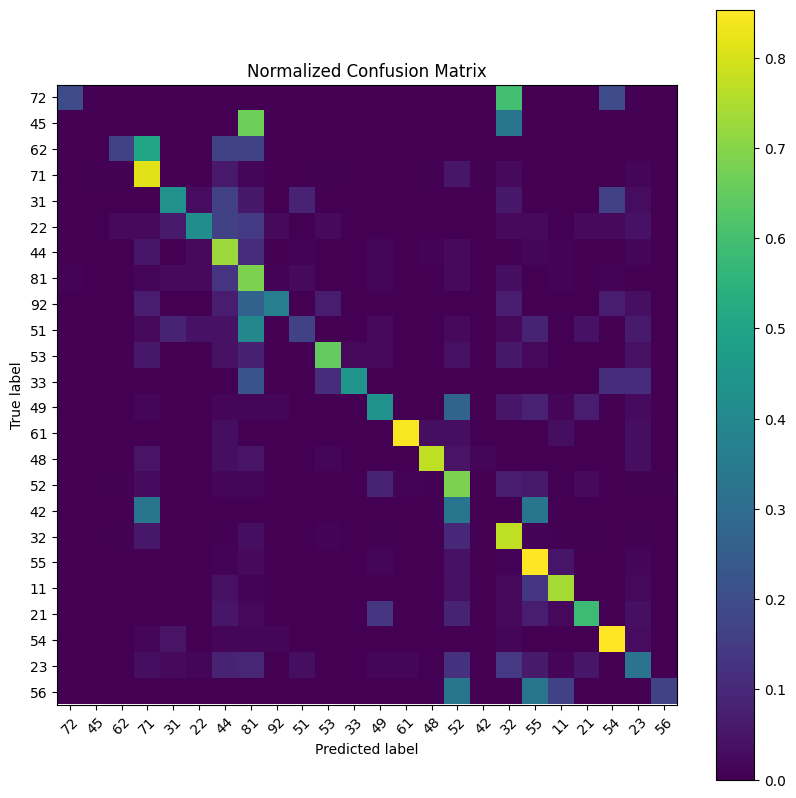

In [62]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

# normalize the confusion matrix
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest")
plt.title("Normalized Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(df["NAICS_2"].unique()))
plt.xticks(tick_marks, df["NAICS_2"].unique(), rotation=45)
plt.yticks(tick_marks, df["NAICS_2"].unique())

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

There are several classes that are predicted when they should not while there are others that aren't even predicted once.

This happens a lot with 81, 52 and 55 classes
